In [1]:
import os
import random
import shutil
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import json
import torch
import torchvision.models as models
import torch.nn as nn
from torch.nn import functional as F
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
%matplotlib inline

## Data exploration

#### Data sampling

In [3]:
data_path = "/home/angel/computer_vision/car-grouping/image_test"
image_list = os.listdir(data_path)

In [10]:
# check how many images are in our dataset
len(image_list)

11579

In [15]:
# lets randomly create a subset of images to label
r_img_list = random.sample(image_list, 1000)
print(len(r_img_list))
r_img_list = [os.path.join(data_path,i) for i in r_img_list]

1000


In [35]:
# Display a random subset (25 images) for sanity check
def image_viz(img_list):
    fig=plt.figure(figsize=(8, 8))
    # Define row and cols in the figure
    rows, cols = 5, 5
    # Display first four images
    images = random.sample(img_list, 25)
    for j in range(0, cols*rows):
        fig.add_subplot(rows, cols, j+1)
        img = plt.imread(images[j])
        plt.imshow(img)
        plt.axis("off")
    plt.show()

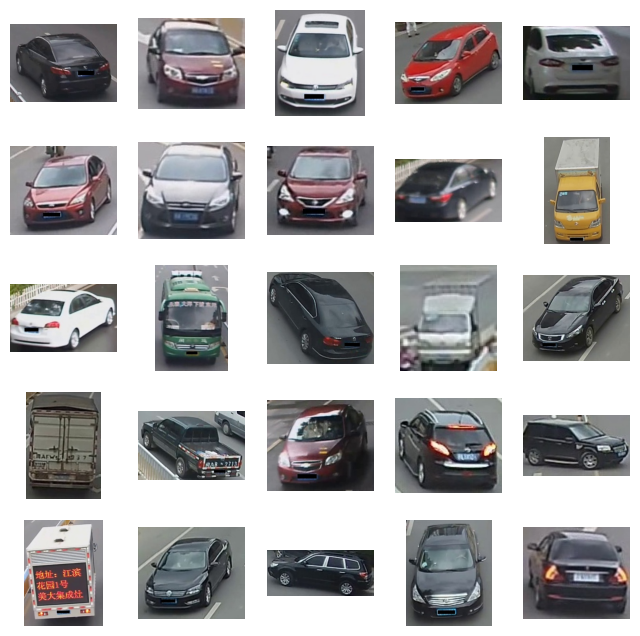

In [36]:
image_viz(r_img_list)

In [45]:
# save subset of images for labeling
dst_path = "/home/angel/computer_vision/car-grouping/subset/"
for src in r_img_list:
    f_name = src.split("/")[-1].
    dst = os.path.join(dst_path, f_name)
    shutil.copyfile(src, dst)
# verify copied files
print(len(os.listdir(dst_path)))

1000


#### Lets check the data distribution

In [144]:
with open('/home/angel/computer_vision/car-grouping/labels/default.json') as json_file:
  labels_file = json.load(json_file)

In [145]:
files = []
colors = []
orientation = []
c_type = []
for l in labels_file['items']:
    an = l['annotations'][0]['attributes']
    files.append(l['id'])
    colors.append(an['color'])
    orientation.append(an['orientation'])
    c_type.append(an['type'])

data = {'file':files, 'color':colors, 'orientation':orientation, 'type':c_type}
labels_df = pd.DataFrame(data)
labels_df

,file,color,orientation,type
0,0002_c005_00085015_0,yellow,br,hatchback
1,0002_c006_00083525_1,yellow,front,hatchback
2,0002_c007_00085070_0,yellow,right,hatchback
3,0002_c011_00083595_0,yellow,front,hatchback
4,0005_c002_00075760_0,orange,back,hatchback
...,...,...,...,...
995,0773_c007_00006850_0,black,fr,sedan
996,0775_c003_00071530_0,black,bl,sedan
997,0775_c003_00071580_0,black,bl,sedan
998,0775_c009_00071690_0,black,bl,sedan


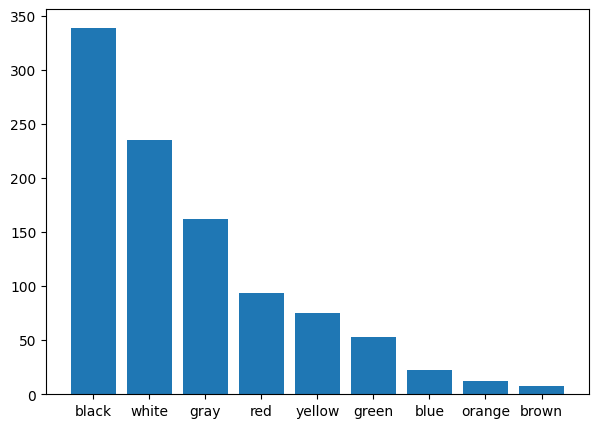

In [146]:
s = labels_df['color'].value_counts()

# Figure Size
fig = plt.figure(figsize =(7, 5))
 
# Horizontal Bar Plot
plt.bar(s.index, s.values)
 
# Show Plot
plt.show()

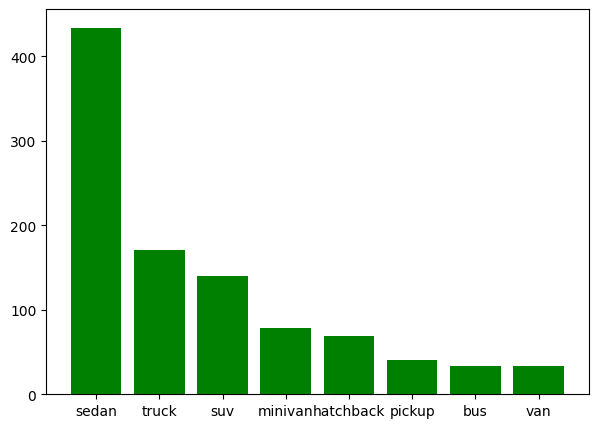

In [147]:
s = labels_df['type'].value_counts()

# Figure Size
fig = plt.figure(figsize =(7, 5))
 
# Horizontal Bar Plot
plt.bar(s.index, s.values, color=['green'])
 
# Show Plot
plt.show()

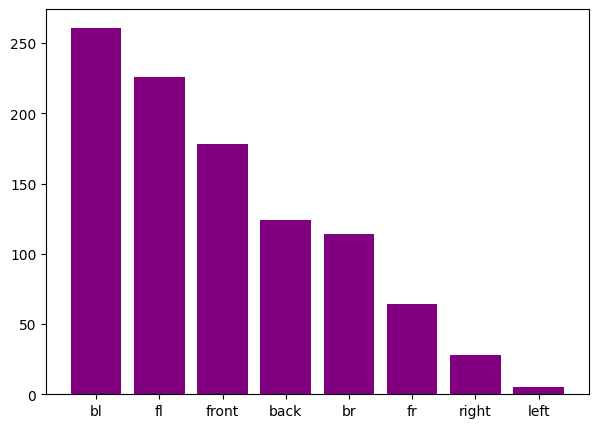

In [148]:
s = labels_df['orientation'].value_counts()

# Figure Size
fig = plt.figure(figsize =(7, 5))
 
# Horizontal Bar Plot
plt.bar(s.index, s.values, color=['purple'])
 
# Show Plot
plt.show()

In [149]:
s

orientation
bl       261
fl       226
front    178
back     124
br       114
fr        64
right     28
left       5
Name: count, dtype: int64

#### Augment and balance

In [150]:
right_cases = labels_df.loc[labels_df['orientation'] == 'right']

In [151]:
src_path = '/home/angel/computer_vision/car-grouping/image_test'
f = right_cases.iloc[0]['file']+'.jpg'
full_path = os.path.join(src_path, f)import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# create dummy data with unbalanced feature value distribution
X = pd.DataFrame(np.concatenate((np.random.randint(0, 3, 500), np.random.randint(0, 10, 500)),axis=0).reshape((500, 2)), columns=["text", "subreddit"])
y = pd.DataFrame(np.random.randint(0,2, 500).reshape((500, 1)), columns=["label"])

# split stratified to target variable and subreddit col
X_train, X_test, y_train, y_test = train_test_split(
    X, pd.concat([X["subreddit"], y], axis=1), stratify=pd.concat([X["subreddit"], y], axis=1))

# remove subreddit cols from target variable arrays
y_train = y_train.drop(["subreddit"], axis=1)
y_test = y_test.drop(["subreddit"], axis=1)
img = plt.imread(full_path)
flip = cv2.flip(img, 1)

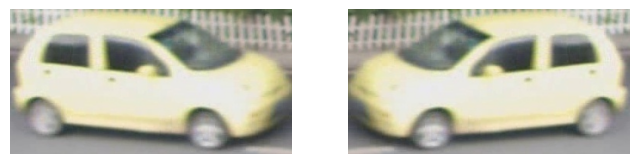

In [152]:
images = [img, flip]
fig=plt.figure(figsize=(8, 8))
# Define row and cols in the figure
rows, cols = 1, 2
# Display first four images
for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    im = images[j]
    plt.imshow(im)
    plt.axis("off")

In [167]:
bl_case = labels_df.loc[labels_df['orientation'] == 'bl']

In [168]:
f = bl_case.iloc[3]['file']+'.jpg'
full_path = os.path.join(src_path, f)
img = plt.imread(full_path)
flip = cv2.flip(img, 1)

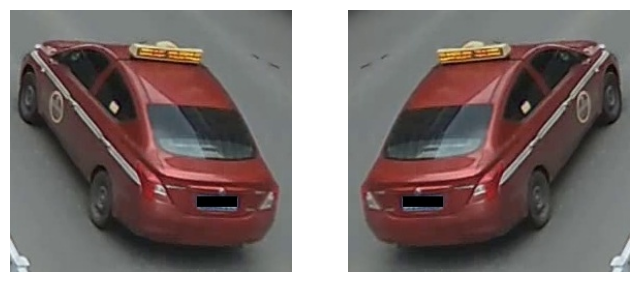

In [169]:
images = [img, flip]
fig=plt.figure(figsize=(8, 8))
# Define row and cols in the figure
rows, cols = 1, 2
# Display first four images
for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    im = images[j]
    plt.imshow(im)
    plt.axis("off")

In [203]:
def flip_and_balance(A, B, a_or, b_or):
    src_path = '/home/angel/computer_vision/car-grouping/subset'
    a_aug= []
    b_aug = []
    for i,row in A.iterrows():
        f = row['file']+'.jpg'
        new_f = row['file']+'_flip'
        full_path = os.path.join(src_path, f)
        img = plt.imread(full_path)
        flip = cv2.flip(img, 1)
        save_path = os.path.join(src_path, new_f+'.jpg')
        plt.imsave(save_path, flip)
        b_aug.append({'file':new_f, 'color':row['color'], 'orientation':b_or, 'type':row['type']})

    for i,row in B.iterrows():
        f = row['file']+'.jpg'
        new_f = row['file']+'_flip'
        full_path = os.path.join(src_path, f)
        img = plt.imread(full_path)
        flip = cv2.flip(img, 1)
        save_path = os.path.join(src_path, new_f+'.jpg')
        plt.imsave(save_path, flip)
        a_aug.append({'file':new_f, 'color':row['color'], 'orientation':a_or, 'type':row['type']})

    return a_aug, b_aug

In [204]:
# balance left and right
left_cases = labels_df.loc[labels_df['orientation'] == 'left']
right_cases = labels_df.loc[labels_df['orientation'] == 'right']
print(len(left_cases), len(right_cases))

5 28


In [205]:
new_l, new_r = flip_and_balance(left_cases, right_cases, 'left', 'right')

In [206]:
new_l_df = pd.DataFrame(new_l)
new_r_df = pd.DataFrame(new_r)
dummy = pd.concat([labels_df, new_l_df, new_r_df], ignore_index=True)


In [207]:
# balance back-left and back-right
bl_cases = labels_df.loc[labels_df['orientation'] == 'bl']
br_cases = labels_df.loc[labels_df['orientation'] == 'br']
print(len(bl_cases), len(br_cases))
new_bl, new_br = flip_and_balance(bl_cases, br_cases, 'bl', 'br')
print(len(new_bl), len(new_br))
new_bl_df = pd.DataFrame(new_bl)
new_br_df = pd.DataFrame(new_br)
dummy = pd.concat([dummy, new_bl_df, new_br_df], ignore_index=True)

261 114
114 261


In [208]:
# balance front-left and front-right
fl_cases = labels_df.loc[labels_df['orientation'] == 'fl']
fr_cases = labels_df.loc[labels_df['orientation'] == 'fr']
print(len(fl_cases), len(fr_cases))
new_fl, new_fr = flip_and_balance(fl_cases, fr_cases, 'fl', 'fr')
print(len(new_fl), len(new_fr))
new_fl_df = pd.DataFrame(new_fl)
new_fr_df = pd.DataFrame(new_fr)
dummy = pd.concat([dummy, new_fl_df, new_fr_df], ignore_index=True)

226 64
64 226


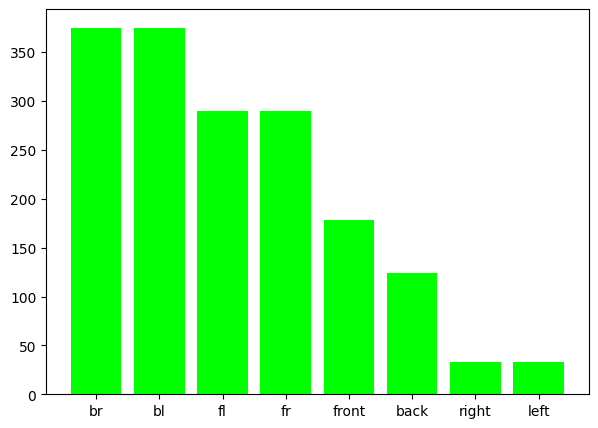

In [209]:
s = dummy['orientation'].value_counts()

# Figure Size
fig = plt.figure(figsize =(7, 5))
 
# Horizontal Bar Plot
plt.bar(s.index, s.values, color=['lime'])
 
# Show Plot
plt.show()

In [202]:
dummy.to_csv('./labels/data_label.csv')

In [220]:
# Let split training, validation and test data with stratified orientation
X_train, X_test = train_test_split(dummy, test_size=0.3, stratify=dummy['orientation'], random_state=42)

orientation
bl       262
br       262
fr       203
fl       203
front    125
back      87
right     23
left      23
Name: count, dtype: int64


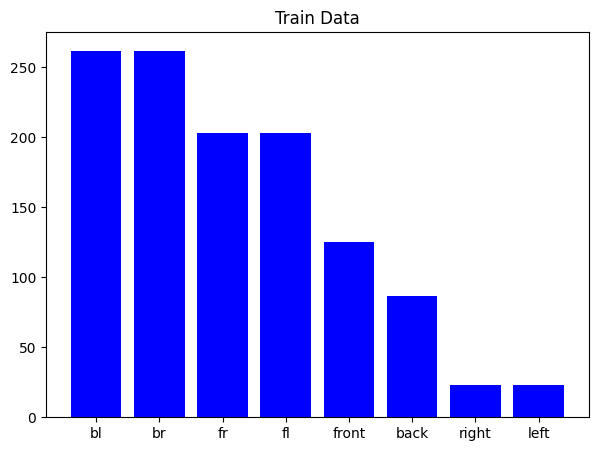

In [226]:
s = X_train['orientation'].value_counts()
print(s)

# Figure Size
fig = plt.figure(figsize =(7, 5))

# Horizontal Bar Plot
plt.bar(s.index, s.values, color=['blue'])
plt.title("Train Data")

# Show Plot
plt.show()

orientation
br       113
bl       113
fl        87
fr        87
front     53
back      37
right     10
left      10
Name: count, dtype: int64


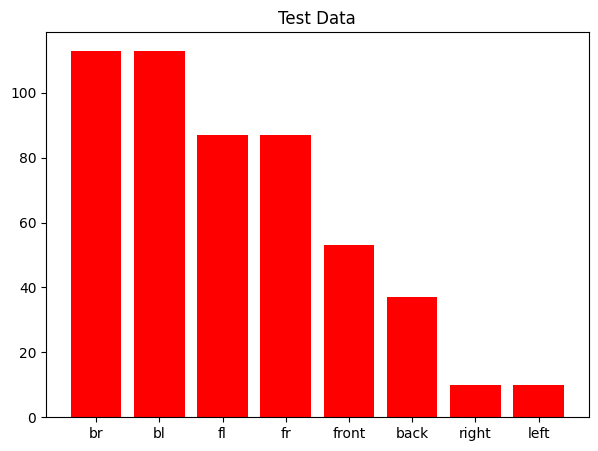

In [227]:
s = X_test['orientation'].value_counts()
print(s)

# Figure Size
fig = plt.figure(figsize =(7, 5))
 
# Horizontal Bar Plot
plt.bar(s.index, s.values, color=['red'])
plt.title("Test Data")
 
# Show Plot
plt.show()

In [231]:
X_val, X_test = train_test_split(X_test, test_size=0.3, random_state=42)

In [236]:
# save split data for training, validation and testing
X_train.to_csv('./labels/train_data.csv', index=False)
X_val.to_csv('./labels/val_data.csv', index=False)
X_test.to_csv('./labels/test_data.csv', index=False)

### Model Trainig

##### Because our dataset is significant but not too big, we will be using a smaller model that should be able to learn the desired function. For this, we will use resnet18, with pretrained weights for knowledge transfer, reducing the training time by a bit. The model architecture will also be modified, specifically the head. There are several ways of approaching this problem, but I have decided to try something new for me, a multi-head model! We have three categories (color, type, and orientation) we want to classify, so the model will be modify at the last layer.

#### Note that we will call the pipeline from this notebook, but for the specific implementation take a look at config.py for the settings and parameters, at dataset.py for the handling of the data, and finaly at train.py for the whole implementation. 

In [ ]:
!python3 train.py

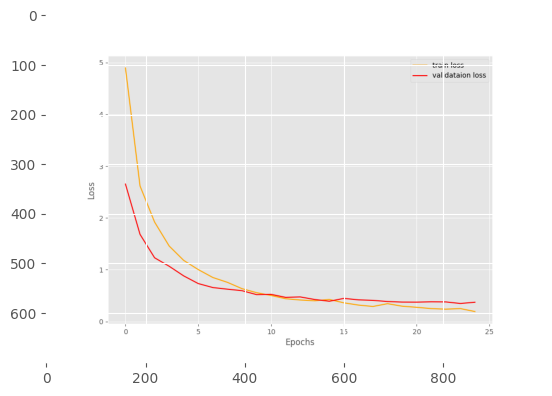

In [27]:
# lets see the training graph
graph = plt.imread('model/loss_Resnet18_car.png')
plt.imshow(graph)

#### Model Testing

In [ ]:
# The augmentations applied during training we a bit more aggressive than for validation, 
# that helped to avoid overfitting, aswell as reduced number of epochs.

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.models import resnet18

class CNN(nn.Module):
    def __init__(self, pretrained):
        super(CNN, self).__init__()
        if pretrained is True:
            self.model = resnet18(weights='DEFAULT')
        else:
            self.model = resnet18()
            
        self.fc1 = nn.Linear(512, 10)  #For color class
        self.fc2 = nn.Linear(512, 8)    #For type class
        self.fc3 = nn.Linear(512, 8)    #For orientation class
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        label1 = self.fc1(x)
        label2 = self.fc2(x)
        label3 = self.fc3(x)
        return {'label1': label1, 'label2': label2, 'label3': label3}

In [5]:
car_model = CNN(pretrained=False).to(DEVICE)
best_model_cp = torch.load("model/final_model_Resnet18_car.pth")
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")
car_model.load_state_dict(best_model_cp['model_state_dict'])

Best model was saved at 25 epochs



<All keys matched successfully>

In [12]:
summary(car_model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [13]:
from dataset import CarDataset
from torch.utils.data import DataLoader
import config
from utils import get_prediction, plot_confusion_matrix

test_ds = CarDataset(
    csv_file="labels/test_data.csv",
    transform=config.test_transforms,
    train=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY,
    shuffle=False,
)

In [15]:
df_ans = get_prediction(test_loader, car_model, DEVICE)

##### Color Metrics

Confusion matrix, without normalization
[[17  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  1  0  0]
 [ 0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0 49  0  0  0]
 [ 0  0  0  0  0  0 34  0  1]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  1  0 21]]


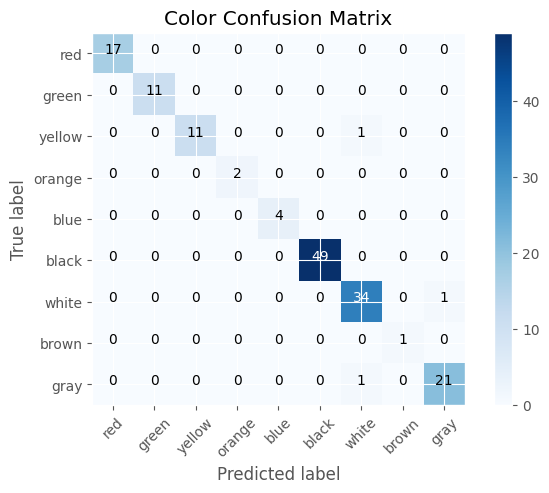

In [26]:
gt = df_ans['gt_color'].to_list()
pred = df_ans['pred_color'].to_list()
cm = confusion_matrix(y_true=gt, y_pred=pred)
cm_plot_labels = ['red', 'green', 'yellow', 'orange', 'blue', 'black', 'white', 'brown', 'gray']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Color Confusion Matrix')

In [27]:
print(classification_report(gt, pred))
print("Accuracy: ", np.mean(cm.diagonal()/cm.sum(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        11
           2       1.00      0.92      0.96        12
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           6       1.00      1.00      1.00        49
           7       0.94      0.97      0.96        35
           8       1.00      1.00      1.00         1
           9       0.95      0.95      0.95        22

    accuracy                           0.98       153
   macro avg       0.99      0.98      0.99       153
weighted avg       0.98      0.98      0.98       153

Accuracy:  0.9825156325156326


##### Type Metrics

Confusion matrix, without normalization
[[ 5  3  1  0  0  0  0  0]
 [ 1 69  0  0  2  0  0  0]
 [ 0  2  9  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0]
 [ 0  1  0  0 15  1  0  0]
 [ 0  0  0  1  1  7  0  0]
 [ 0  0  0  0  0  0 22  0]
 [ 0  0  0  0  0  0  0  7]]


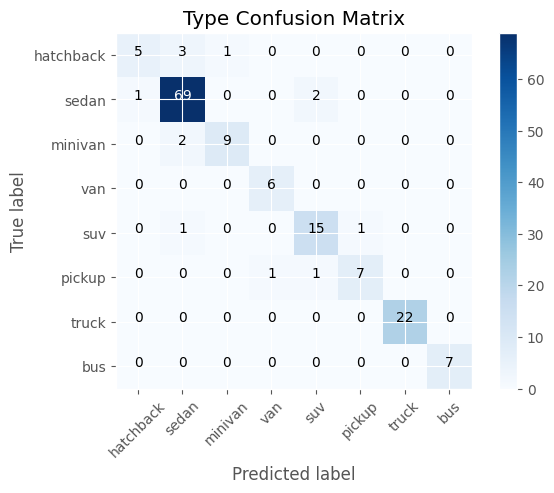

In [28]:
gt = df_ans['gt_type'].to_list()
pred = df_ans['pred_type'].to_list()
cm = confusion_matrix(y_true=gt, y_pred=pred)
cm_plot_labels = ['hatchback', 'sedan', 'minivan', 'van', 'suv', 'pickup', 'truck', 'bus']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Type Confusion Matrix')

In [29]:
print(classification_report(gt, pred))
print("Accuracy: ", np.mean(cm.diagonal()/cm.sum(axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.92      0.96      0.94        72
           2       0.90      0.82      0.86        11
           3       0.86      1.00      0.92         6
           4       0.83      0.88      0.86        17
           5       0.88      0.78      0.82         9
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00         7

    accuracy                           0.92       153
   macro avg       0.90      0.87      0.88       153
weighted avg       0.91      0.92      0.91       153

Accuracy:  0.8740251782531194


##### Orientation Metrics

Confusion matrix, without normalization
[[15  0  1  0  0  0  0  0]
 [ 0 11  0  0  2  0  0  0]
 [ 0  0 27  1  0  0  0  0]
 [ 0  0  0 25  0  0  0  0]
 [ 0  1  0  0 34  0  0  0]
 [ 0  1  0  0  2 27  0  0]
 [ 0  0  0  0  0  0  3  1]
 [ 0  0  0  0  0  0  1  1]]


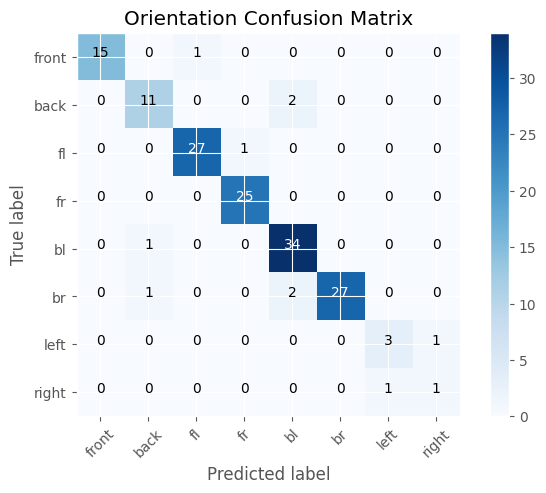

In [30]:
gt = df_ans['gt_orientation'].to_list()
pred = df_ans['pred_orientation'].to_list()
cm = confusion_matrix(y_true=gt, y_pred=pred)
cm_plot_labels = ['front', 'back', 'fl', 'fr', 'bl', 'br', 'left', 'right']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Orientation Confusion Matrix')

In [31]:
print(classification_report(gt, pred))
print("Accuracy: ", np.mean(cm.diagonal()/cm.sum(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.85      0.85      0.85        13
           2       0.96      0.96      0.96        28
           3       0.96      1.00      0.98        25
           4       0.89      0.97      0.93        35
           5       1.00      0.90      0.95        30
           6       0.75      0.75      0.75         4
           7       0.50      0.50      0.50         2

    accuracy                           0.93       153
   macro avg       0.86      0.86      0.86       153
weighted avg       0.94      0.93      0.93       153

Accuracy:  0.8586710164835165


In [33]:
color_plot = cv2.imread("display/cm_color.png")
type_plot = cv2.imread("display/cm_type.png")
ori_plot = cv2.imread("display/cm_ori.png")
cms = cv2.hconcat([color_plot, type_plot, ori_plot])
cv2.imwrite("display/cms.png", cms)

True

#### Model Optimization

In [14]:
import os
import torch
from torch.onnx import export, TrainingMode

class ONNXExporter:
    def __init__(self, model, device, onnx_path: str):
        # Initialization with model, device, and ONNX path
        self.model = model
        self.onnx_path = onnx_path
        self.device = device

    def export_model(self):
        # Set the model to evaluation mode
        self.model.to(self.device)
        self.model.eval()

        # Define a dummy input tensor
        x = torch.randn(1, 3, 128, 128).to(self.device)

        # Export the model to ONNX format
        if not os.path.exists(self.onnx_path):
            os.makedirs("models", exist_ok=True)
        export(
            self.model, x, self.onnx_path, training=TrainingMode.EVAL, verbose=True,
            input_names=["input"], output_names=["color", "type", "orientation"]
        )

        print(f"Model exported to {self.onnx_path}")

In [ ]:
ONNXExporter(car_model, 'cpu', './model/final_model_Resnet18_car.onnx').export_model()

In [16]:
import onnx
onnx_model = onnx.load(r"model/final_model_Resnet18_car.onnx")
onnx.checker.check_model(onnx_model)

In [19]:
import torchvision.transforms as transforms 

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
        transforms.Normalize(
                    (0.485, 0.456, 0.406), 
                    (0.229, 0.224, 0.225)),
    ]
)

In [38]:
import onnxruntime as rt

#define the priority order for the execution providers
# prefer CUDA Execution Provider over CPU Execution Provider
EP_list = ['CPUExecutionProvider']

# initialize the model.onnx
sess = rt.InferenceSession("model/final_model_Resnet18_car.onnx", providers=EP_list)

# get the outputs metadata as a list of :class:`onnxruntime.NodeArg`
output_color = sess.get_outputs()[0].name
output_type = sess.get_outputs()[1].name
output_ori = sess.get_outputs()[2].name

# get the inputs metadata as a list of :class:`onnxruntime.NodeArg`
input_name = sess.get_inputs()[0].name

img = cv2.imread("./subset/0002_c005_00085015_0.jpg")
tensor_img = transform(img).numpy()
tensor_img = tensor_img[None,:,:,:]
# inference run using image_data as the input to the model 
detections = sess.run([output_color, output_type, output_ori], {input_name: tensor_img})

print("Output shape:", len(detections))

Output shape: 3


In [50]:
def sess_run(sess, img):
    sess.run([output_color, output_type, output_ori], {input_name: img})

In [39]:
from time import perf_counter

def timer(f,*args):   
    start = perf_counter()
    f(*args)
    return (1000 * (perf_counter() - start))

In [51]:
x_ft = torch.rand(1, 3, 128, 128).to("cpu")
x_np = x_ft.numpy()
car_model.to("cpu").eval()
print(f"Pytorch Model: {np.mean([timer(car_model,x_ft) for _ in range(1000)])} ms")
print(f"Onnx Model: {np.mean([timer(sess_run, sess, x_np) for _ in range(1000)])} ms")

Pytorch Model: 6.649396909022471 ms
Onnx Model: 3.4263269931834657 ms


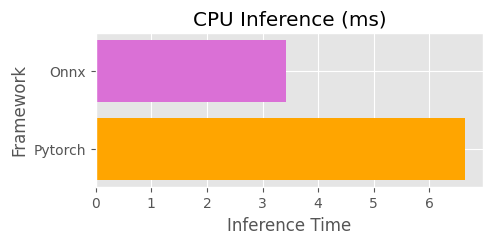

In [60]:
name = ['Pytorch', 'Onnx']
time = [6.64, 3.42]
c = ['orange', 'orchid']
 
# Figure Size
fig = plt.figure(figsize =(5, 2))
 
# Horizontal Bar Plot
plt.barh(name, time, color=c)
plt.xlabel("Inference Time")
plt.ylabel("Framework")
plt.title("CPU Inference (ms)")
# Show Plot
plt.show()